#BERT
Based on [codertimo/BERT-pytorch](https://github.com/codertimo/BERT-pytorch)

In [1]:
!pip install sentencepiece

--2025-11-28 11:07:36--  https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf [following]
--2025-11-28 11:07:36--  https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2054744 (2.0M) [application/octet-stream]
Saving to: ‘NanumGothic-Regular.ttf’

NanumGothic-Regular 100%[===================>]   1.96M  --.-KB/s    in 0.007s  

2025-11-28 11:07:37 (298 MB/s) - ‘NanumGothic-Re

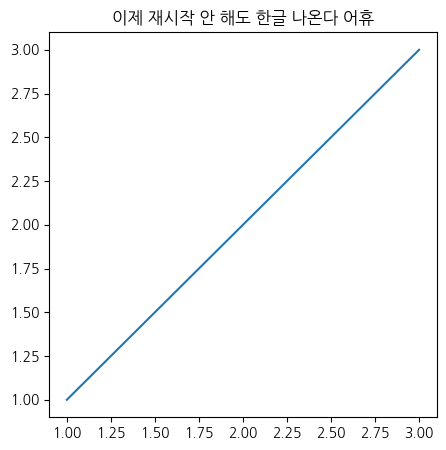

In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

!wget 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'

fm.fontManager.addfont('NanumGothic-Regular.ttf')

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(5,5))
plt.plot([1, 2, 3], [1, 2, 3])
plt.title('이제 재시작 안 해도 한글 나온다 어휴')
plt.show()

---
## 1. Configuration

In [2]:
import os
from dataclasses import dataclass
from typing import Optional

@dataclass
class BERTConfig:
    # Data
    corpus_path: str = "kowiki.txt"
    vocab_path: str = "kowiki_vocab"
    output_dir: str = "output"

    # Tokenizer (SentencePiece)
    vocab_size: int = 8000

    # Model architecture
    hidden_size: int = 64
    num_layers: int = 2
    num_attention_heads: int = 4
    intermediate_size: int = 256
    hidden_dropout_prob: float = 0.1
    attention_probs_dropout_prob: float = 0.1
    max_position_embeddings: int = 256

    # Training
    batch_size: int = 256
    num_epochs: int = 10
    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 0.01
    warmup_steps: int = 10000

    # MLM
    mlm_probability: float = 0.15

    # Device
    device: str = "cuda"
    num_workers: int = 0

    # Logging
    log_freq: int = 100
    save_freq: int = 1

config = BERTConfig()
os.makedirs(config.output_dir, exist_ok=True)
print(f"Config: hidden={config.hidden_size}, layers={config.num_layers}, heads={config.num_attention_heads}")

Config: hidden=64, layers=2, heads=4


---
## 2. Imports and Setup

In [3]:
import re
import math
import random
import pickle
from collections import Counter
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

import sentencepiece as spm

if config.device == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
elif config.device == "mps" and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


---
## 3. Data Preprocessing

In [4]:
def preprocess_kowiki(input_path: str, output_path: str) -> int:
    doc_pattern = re.compile(r'<doc[^>]*>')

    total_pairs = 0
    with open(input_path, 'r', encoding='utf-8') as f_in, \
         open(output_path, 'w', encoding='utf-8') as f_out:

        current_doc_sentences = []

        for line in tqdm(f_in, desc="Processing kowiki"):
            line = line.strip()

            if doc_pattern.match(line) or line == '</doc>' or not line:
                if len(current_doc_sentences) >= 2:
                    for i in range(len(current_doc_sentences) - 1):
                        sent_a = current_doc_sentences[i]
                        sent_b = current_doc_sentences[i + 1]
                        if len(sent_a) > 10 and len(sent_b) > 10:
                            f_out.write(f"{sent_a}\t{sent_b}\n")
                            total_pairs += 1
                current_doc_sentences = []
                continue

            sentences = re.split(r'(?<=[.!?])\s+', line)
            for sent in sentences:
                sent = sent.strip()
                if sent:
                    current_doc_sentences.append(sent)

    print(f"Created {total_pairs} sentence pairs")
    return total_pairs

In [5]:
corpus_processed_path = config.corpus_path.replace('.txt', '_processed.txt')

if not os.path.exists(corpus_processed_path):
    print(f"Preprocessing {config.corpus_path}...")
    preprocess_kowiki(config.corpus_path, corpus_processed_path)
else:
    print(f"Using existing: {corpus_processed_path}")

Using existing: kowiki_processed.txt


---
## 4. Vocabulary (SentencePiece)

In [6]:
class Vocabulary:
    PAD_IDX = 0
    UNK_IDX = 1
    CLS_IDX = 2
    SEP_IDX = 3
    MASK_IDX = 4

    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path + '.model')
        self._vocab_size = self.sp.GetPieceSize()

    def __len__(self) -> int:
        return self._vocab_size

    def tokenize(self, text: str) -> List[str]:
        return self.sp.EncodeAsPieces(text)

    def encode(self, text: str) -> List[int]:
        return self.sp.EncodeAsIds(text)

    def decode(self, ids: List[int]) -> str:
        return self.sp.DecodeIds(ids)

    def token_to_id(self, token: str) -> int:
        return self.sp.PieceToId(token)

    def id_to_token(self, idx: int) -> str:
        return self.sp.IdToPiece(idx)


def train_sentencepiece(input_path: str, model_prefix: str, vocab_size: int):
    spm.SentencePieceTrainer.Train(
        input=input_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        pad_id=0, pad_piece='[PAD]',
        unk_id=1, unk_piece='[UNK]',
        bos_id=2, bos_piece='[CLS]',
        eos_id=3, eos_piece='[SEP]',
        user_defined_symbols=['[MASK]'],
        character_coverage=0.9995,
        num_threads=os.cpu_count(),
    )
    print(f"SentencePiece model saved: {model_prefix}.model")

In [7]:
if not os.path.exists(config.vocab_path + '.model'):
    print("Training SentencePiece...")
    train_sentencepiece(config.corpus_path, config.vocab_path, config.vocab_size)

vocab = Vocabulary(config.vocab_path)
print(f"Vocab size: {len(vocab)}")

Vocab size: 8000


---
## 5. Dataset

In [8]:
class BERTDataset(Dataset):
    def __init__(
        self,
        corpus_path: str,
        vocab: Vocabulary,
        seq_len: int,
        encoding: str = "utf-8",
        on_memory: bool = True
    ):
        self.vocab = vocab
        self.seq_len = seq_len
        self.on_memory = on_memory
        self.corpus_path = corpus_path
        self.encoding = encoding

        with open(corpus_path, 'r', encoding=encoding) as f:
            if on_memory:
                self.lines = [
                    line.strip().split('\t')
                    for line in tqdm(f, desc="Loading Dataset")
                    if '\t' in line
                ]
                self.corpus_lines = len(self.lines)
            else:
                self.corpus_lines = sum(1 for _ in f)

        if not on_memory:
            self.file = open(corpus_path, 'r', encoding=encoding)
            self.random_file = open(corpus_path, 'r', encoding=encoding)

    def __len__(self) -> int:
        return self.corpus_lines

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        t1, t2, is_next = self.get_sentence_pair(idx)

        t1_tokens = self.vocab.encode(t1)
        t2_tokens = self.vocab.encode(t2)

        t1_tokens, t1_labels = self.random_word(t1_tokens)
        t2_tokens, t2_labels = self.random_word(t2_tokens)

        cls_token = [Vocabulary.CLS_IDX]
        sep_token = [Vocabulary.SEP_IDX]

        max_len = self.seq_len - 3
        if len(t1_tokens) + len(t2_tokens) > max_len:
            total_len = len(t1_tokens) + len(t2_tokens)
            t1_len = int(max_len * len(t1_tokens) / total_len)
            t2_len = max_len - t1_len
            t1_tokens = t1_tokens[:t1_len]
            t1_labels = t1_labels[:t1_len]
            t2_tokens = t2_tokens[:t2_len]
            t2_labels = t2_labels[:t2_len]

        input_ids = cls_token + t1_tokens + sep_token + t2_tokens + sep_token
        segment_ids = [0] * (len(t1_tokens) + 2) + [1] * (len(t2_tokens) + 1)
        mlm_labels = [Vocabulary.PAD_IDX] + t1_labels + [Vocabulary.PAD_IDX] + t2_labels + [Vocabulary.PAD_IDX]

        padding_len = self.seq_len - len(input_ids)
        input_ids += [Vocabulary.PAD_IDX] * padding_len
        segment_ids += [0] * padding_len
        mlm_labels += [Vocabulary.PAD_IDX] * padding_len
        attention_mask = [1] * (self.seq_len - padding_len) + [0] * padding_len

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'segment_ids': torch.tensor(segment_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'mlm_labels': torch.tensor(mlm_labels, dtype=torch.long),
            'is_next': torch.tensor(is_next, dtype=torch.long)
        }

    def get_sentence_pair(self, idx: int) -> Tuple[str, str, int]:
        if self.on_memory:
            line = self.lines[idx]
        else:
            line = self.get_corpus_line(idx)

        t1 = line[0] if len(line) > 0 else ""

        if random.random() > 0.5:
            t2 = line[1] if len(line) > 1 else ""
            is_next = 1
        else:
            t2 = self.get_random_line()
            is_next = 0

        return t1, t2, is_next

    def random_word(self, tokens: List[int]) -> Tuple[List[int], List[int]]:
        output_tokens = []
        output_labels = []

        for token in tokens:
            prob = random.random()

            if prob < 0.15:
                prob /= 0.15

                if prob < 0.8:
                    output_tokens.append(Vocabulary.MASK_IDX)
                elif prob < 0.9:
                    output_tokens.append(random.randint(5, len(self.vocab) - 1))
                else:
                    output_tokens.append(token)

                output_labels.append(token)
            else:
                output_tokens.append(token)
                output_labels.append(Vocabulary.PAD_IDX)

        return output_tokens, output_labels

    def get_corpus_line(self, idx: int) -> List[str]:
        self.file.seek(0)
        for i, line in enumerate(self.file):
            if i == idx:
                return line.strip().split('\t')
        return []

    def get_random_line(self) -> str:
        if self.on_memory:
            rand_idx = random.randint(0, self.corpus_lines - 1)
            line = self.lines[rand_idx]
            return line[random.randint(0, len(line) - 1)] if line else ""
        else:
            self.random_file.seek(0)
            for _ in range(random.randint(0, self.corpus_lines - 1)):
                self.random_file.readline()
            line = self.random_file.readline().strip().split('\t')
            return line[0] if line else ""

In [9]:
train_dataset = BERTDataset(
    corpus_path=corpus_processed_path,
    vocab=vocab,
    seq_len=config.max_position_embeddings,
    on_memory=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"Dataset: {len(train_dataset)}, Batches: {len(train_loader)}")

Loading Dataset: 988666it [00:03, 284259.35it/s]

Dataset: 988666, Batches: 3862


---
## 6. Model Components

In [10]:
# 6.1 Embeddings

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size: int, embed_size: int):
        super().__init__(vocab_size, embed_size, padding_idx=Vocabulary.PAD_IDX)


class PositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, embed_size: int):
        super().__init__()
        self.embedding = nn.Embedding(max_len, embed_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        return self.embedding(positions)


class SegmentEmbedding(nn.Embedding):
    def __init__(self, embed_size: int):
        super().__init__(2, embed_size)


class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, max_len: int, dropout: float = 0.1):
        super().__init__()
        self.token = TokenEmbedding(vocab_size, embed_size)
        self.position = PositionalEmbedding(max_len, embed_size)
        self.segment = SegmentEmbedding(embed_size)
        self.norm = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids: torch.Tensor, segment_ids: torch.Tensor) -> torch.Tensor:
        x = self.token(input_ids) + self.position(input_ids) + self.segment(segment_ids)
        return self.dropout(self.norm(x))

In [11]:
# 6.2 Attention

class Attention(nn.Module):
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        dropout: Optional[nn.Dropout] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_probs = F.softmax(scores, dim=-1)

        if dropout is not None:
            attn_probs = dropout(attn_probs)

        return torch.matmul(attn_probs, value), attn_probs


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, d_model: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)

        self.attention = Attention()
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        batch_size = query.size(0)

        query = self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.linear_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.linear_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # if mask is not None:
        #     mask = mask.unsqueeze(1)

        x, _ = self.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linear_out(x)

In [12]:
# 6.3 Feed-Forward & Transformer Block

class GELU(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(self.activation(self.w1(x))))


class SublayerConnection(nn.Module):
    def __init__(self, size: int, dropout: float):
        super().__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, sublayer: nn.Module) -> torch.Tensor:
        return x + self.dropout(sublayer(self.norm(x)))


class TransformerBlock(nn.Module):
    def __init__(self, hidden: int, attn_heads: int, feed_forward_hidden: int, dropout: float):
        super().__init__()
        self.attention = MultiHeadAttention(attn_heads, hidden, dropout)
        self.feed_forward = PositionwiseFeedForward(hidden, feed_forward_hidden, dropout)
        self.input_sublayer = SublayerConnection(hidden, dropout)
        self.output_sublayer = SublayerConnection(hidden, dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.input_sublayer(x, lambda _x: self.attention(_x, _x, _x, mask))
        x = self.output_sublayer(x, self.feed_forward)
        return x

In [13]:
# 6.4 BERT Model

class BERT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        hidden: int = 256,
        n_layers: int = 8,
        attn_heads: int = 8,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads
        self.feed_forward_hidden = hidden * 4

        self.embedding = BERTEmbedding(vocab_size, hidden, max_len, dropout)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden, attn_heads, self.feed_forward_hidden, dropout)
            for _ in range(n_layers)
        ])

    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2)
        else:
            mask = None

        x = self.embedding(input_ids, segment_ids)

        for transformer in self.transformer_blocks:
            x = transformer(x, mask)

        return x

In [14]:
# 6.5 Pre-training Heads (MLM + NSP)

class MaskedLanguageModel(nn.Module):
    def __init__(self, hidden: int, vocab_size: int):
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


class NextSentencePrediction(nn.Module):
    def __init__(self, hidden: int):
        super().__init__()
        self.linear = nn.Linear(hidden, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x[:, 0])


class BERTLM(nn.Module):
    def __init__(self, bert: BERT, vocab_size: int):
        super().__init__()
        self.bert = bert
        self.mlm = MaskedLanguageModel(bert.hidden, vocab_size)
        self.nsp = NextSentencePrediction(bert.hidden)

    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.bert(input_ids, segment_ids, attention_mask)
        return self.mlm(x), self.nsp(x)

---
## 7. Trainer

In [15]:
class BERTTrainer:
    def __init__(
        self,
        model: BERTLM,
        train_loader: DataLoader,
        vocab_size: int,
        lr: float = 1e-4,
        betas: Tuple[float, float] = (0.9, 0.999),
        weight_decay: float = 0.01,
        warmup_steps: int = 10000,
        device: torch.device = torch.device("cpu"),
        log_freq: int = 100
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.device = device
        self.log_freq = log_freq

        self.optimizer = AdamW(
            model.parameters(),
            lr=lr,
            betas=betas,
            weight_decay=weight_decay
        )

        self.total_steps = len(train_loader)
        self.warmup_steps = warmup_steps
        self.scheduler = self._get_scheduler()

        self.mlm_criterion = nn.CrossEntropyLoss(ignore_index=Vocabulary.PAD_IDX)
        self.nsp_criterion = nn.CrossEntropyLoss()

        print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

    def _get_scheduler(self) -> LambdaLR:
        def lr_lambda(step):
            if step < self.warmup_steps:
                return float(step) / float(max(1, self.warmup_steps))
            return 1.0
        return LambdaLR(self.optimizer, lr_lambda)

    def train(self, epoch: int) -> Tuple[float, float, float]:
        self.model.train()

        total_loss = 0.0
        total_correct_mlm = 0
        total_mlm_elements = 0
        total_correct_nsp = 0
        total_nsp_elements = 0

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch}")

        for i, batch in enumerate(pbar):
            input_ids = batch['input_ids'].to(self.device)
            segment_ids = batch['segment_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            mlm_labels = batch['mlm_labels'].to(self.device)
            is_next = batch['is_next'].to(self.device)

            mlm_output, nsp_output = self.model(input_ids, segment_ids, attention_mask)

            mlm_loss = self.mlm_criterion(
                mlm_output.view(-1, mlm_output.size(-1)),
                mlm_labels.view(-1)
            )
            nsp_loss = self.nsp_criterion(nsp_output, is_next)
            loss = mlm_loss + nsp_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            mlm_mask = mlm_labels != Vocabulary.PAD_IDX
            if mlm_mask.sum() > 0:
                mlm_pred = mlm_output.argmax(dim=-1)
                total_correct_mlm += (mlm_pred[mlm_mask] == mlm_labels[mlm_mask]).sum().item()
                total_mlm_elements += mlm_mask.sum().item()

            nsp_pred = nsp_output.argmax(dim=-1)
            total_correct_nsp += (nsp_pred == is_next).sum().item()
            total_nsp_elements += is_next.size(0)

            if (i + 1) % self.log_freq == 0:
                avg_loss = total_loss / (i + 1)
                mlm_acc = total_correct_mlm / max(1, total_mlm_elements) * 100
                nsp_acc = total_correct_nsp / max(1, total_nsp_elements) * 100
                pbar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'mlm': f'{mlm_acc:.2f}%',
                    'nsp': f'{nsp_acc:.2f}%'
                })

        n_batches = len(self.train_loader)
        return (
            total_loss / n_batches,
            total_correct_mlm / max(1, total_mlm_elements),
            total_correct_nsp / max(1, total_nsp_elements)
        )

    def save(self, path: str, epoch: int):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict()
        }, path)

    def load(self, path: str) -> int:
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return checkpoint['epoch']

---
## 8. Initialize Model

In [16]:
bert = BERT(
    vocab_size=len(vocab),
    hidden=config.hidden_size,
    n_layers=config.num_layers,
    attn_heads=config.num_attention_heads,
    max_len=config.max_position_embeddings,
    dropout=config.hidden_dropout_prob
)

bert_lm = BERTLM(bert, len(vocab))

trainer = BERTTrainer(
    model=bert_lm,
    train_loader=train_loader,
    vocab_size=len(vocab),
    lr=config.learning_rate,
    betas=(config.adam_beta1, config.adam_beta2),
    weight_decay=config.adam_weight_decay,
    warmup_steps=config.warmup_steps,
    device=device,
    log_freq=config.log_freq
)

Parameters: 1,148,738


---
## 9. Training

In [17]:
history = {'loss': [], 'mlm_acc': [], 'nsp_acc': []}

for epoch in range(1, config.num_epochs + 1):
    loss, mlm_acc, nsp_acc = trainer.train(epoch)

    history['loss'].append(loss)
    history['mlm_acc'].append(mlm_acc)
    history['nsp_acc'].append(nsp_acc)

    print(f"Epoch {epoch}: Loss={loss:.4f}, MLM={mlm_acc*100:.2f}%, NSP={nsp_acc*100:.2f}%")

    if epoch % config.save_freq == 0:
        trainer.save(f"{config.output_dir}/bert_epoch_{epoch}.pt", epoch)

trainer.save(f"{config.output_dir}/bert_final.pt", config.num_epochs)

Epoch 1: 100%|██████████| 3862/3862 [17:52<00:00,  3.60it/s, loss=8.8941, mlm=1.59%, nsp=50.04%]


Epoch 1: Loss=8.8830, MLM=1.61%, NSP=50.04%


Epoch 2: 100%|██████████| 3862/3862 [17:55<00:00,  3.59it/s, loss=8.1481, mlm=3.48%, nsp=50.44%]


Epoch 2: Loss=8.1470, MLM=3.50%, NSP=50.46%


Epoch 3: 100%|██████████| 3862/3862 [17:57<00:00,  3.58it/s, loss=8.0026, mlm=5.54%, nsp=51.68%]


Epoch 3: Loss=8.0012, MLM=5.55%, NSP=51.69%


Epoch 4: 100%|██████████| 3862/3862 [17:56<00:00,  3.59it/s, loss=7.8041, mlm=7.42%, nsp=52.61%]


Epoch 4: Loss=7.8022, MLM=7.44%, NSP=52.62%


Epoch 5: 100%|██████████| 3862/3862 [17:57<00:00,  3.59it/s, loss=7.5977, mlm=9.53%, nsp=54.49%]


Epoch 5: Loss=7.5963, MLM=9.55%, NSP=54.51%


Epoch 6: 100%|██████████| 3862/3862 [17:57<00:00,  3.58it/s, loss=7.4423, mlm=10.90%, nsp=57.49%]


Epoch 6: Loss=7.4413, MLM=10.91%, NSP=57.52%


Epoch 7: 100%|██████████| 3862/3862 [17:58<00:00,  3.58it/s, loss=7.3205, mlm=11.81%, nsp=60.65%]


Epoch 7: Loss=7.3198, MLM=11.82%, NSP=60.67%


Epoch 8: 100%|██████████| 3862/3862 [17:57<00:00,  3.59it/s, loss=7.2314, mlm=12.41%, nsp=62.72%]


Epoch 8: Loss=7.2307, MLM=12.42%, NSP=62.73%


Epoch 9: 100%|██████████| 3862/3862 [17:57<00:00,  3.59it/s, loss=7.1551, mlm=12.92%, nsp=64.20%]


Epoch 9: Loss=7.1547, MLM=12.92%, NSP=64.21%


Epoch 10: 100%|██████████| 3862/3862 [17:57<00:00,  3.58it/s, loss=7.0881, mlm=13.29%, nsp=65.61%]

Epoch 10: Loss=7.0876, MLM=13.29%, NSP=65.61%


---
## 10. Visualization

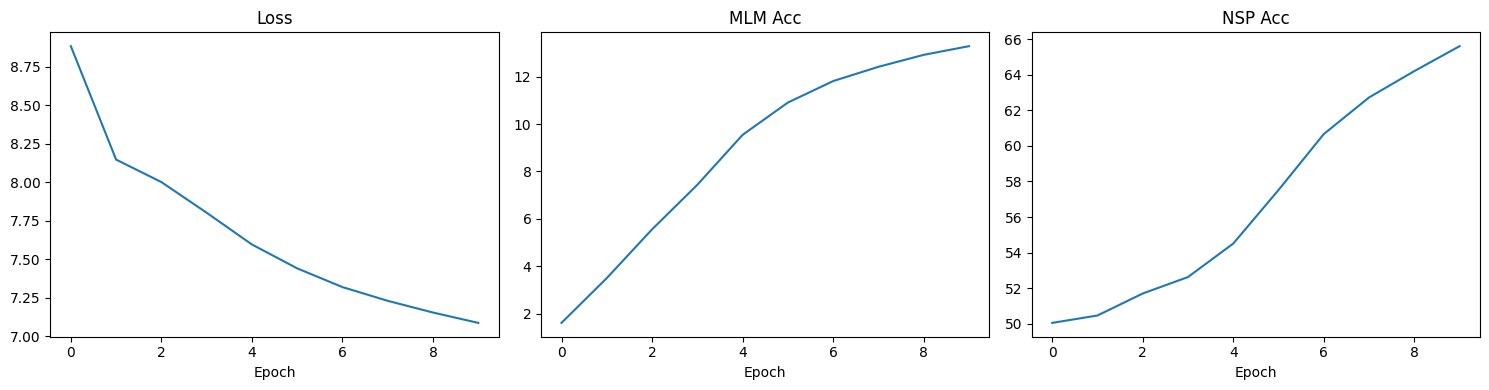

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'])
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')

axes[1].plot([x * 100 for x in history['mlm_acc']])
axes[1].set_title('MLM Acc')
axes[1].set_xlabel('Epoch')

axes[2].plot([x * 100 for x in history['nsp_acc']])
axes[2].set_title('NSP Acc')
axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(f"{config.output_dir}/history.png", dpi=150)
plt.show()

---
## 11. Inference

In [19]:
def predict_masked(model: BERTLM, vocab: Vocabulary, text: str, device: torch.device) -> str:
    model.eval()

    tokens = vocab.encode(text.replace('[MASK]', vocab.id_to_token(Vocabulary.MASK_IDX)))

    input_ids = [Vocabulary.CLS_IDX] + tokens + [Vocabulary.SEP_IDX]
    segment_ids = [0] * len(input_ids)
    attention_mask = [1] * len(input_ids)

    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)
    segment_ids = torch.tensor([segment_ids], dtype=torch.long, device=device)
    attention_mask = torch.tensor([attention_mask], dtype=torch.long, device=device)

    with torch.no_grad():
        mlm_output, _ = model(input_ids, segment_ids, attention_mask)

    mask_positions = (input_ids == Vocabulary.MASK_IDX).nonzero(as_tuple=True)[1]

    result = text
    for pos in mask_positions:
        pred_id = mlm_output[0, pos].argmax().item()
        pred_token = vocab.id_to_token(pred_id)
        result = result.replace('[MASK]', pred_token, 1)

    return result

In [27]:
#무작위 문장들
test_sentences = [
    "대한민국의 수도는 [MASK]이다.",
    "[MASK]은 한국에서 가장 큰 도시이다.",
    "인공지능 기술이 빠르게 [MASK]하고 있다.",
    "노무현은 16대 [MASK] 이다."
]

for sent in test_sentences:
    result = predict_masked(bert_lm, vocab, sent, device)
    print(f"Input:  {sent}")
    print(f"Output: {result}\n")

Input:  대한민국의 수도는 [MASK]이다.
Output: 대한민국의 수도는 은이다.

Input:  [MASK]은 한국에서 가장 큰 도시이다.
Output: 은은 한국에서 가장 큰 도시이다.

Input:  인공지능 기술이 빠르게 [MASK]하고 있다.
Output: 인공지능 기술이 빠르게 ▁수하고 있다.

Input:  노무현은 16대 [MASK] 이다.
Output: 노무현은 16대 을 이다.



In [25]:
#실제 데이터에서 가져온 문장
test_cases = [
    # 화학 관련
    "화학은 물질의 성질, 조성, 구조, [MASK]를 연구하는 자연과학이다",
    "원자는 양성자와 [MASK]로 구성된 원자핵을 가진다",
    "화학 반응에서 에너지가 [MASK]되거나 흡수된다",

    # 노무현 관련
    "노무현은 대한민국의 제[MASK]대 대통령이다",
    "노무현은 [MASK]년에 대통령으로 당선되었다",

    # 물리학 관련
    "맥스웰 방정식은 전기와 [MASK]의 발생을 나타낸다",
    "일반 상대성이론은 [MASK]을 다루는 이론이다",

    # 수학 관련
    "초월수는 [MASK] 방정식의 해가 될 수 없다",
    "방정식의 해를 구하려는 문자를 [MASK]라고 한다",
]

print("=" * 80)
print("실제 데이터 기반 테스트")
print("=" * 80)

for sent in test_cases:
    result = predict_masked(bert_lm, vocab, sent, device)
    print(f"\n입력: {sent}")
    print(f"예측: {result}")
    print("-" * 80)

실제 데이터 기반 테스트

입력: 화학은 물질의 성질, 조성, 구조, [MASK]를 연구하는 자연과학이다
예측: 화학은 물질의 성질, 조성, 구조, ,를 연구하는 자연과학이다
--------------------------------------------------------------------------------

입력: 원자는 양성자와 [MASK]로 구성된 원자핵을 가진다
예측: 원자는 양성자와 ▁로 구성된 원자핵을 가진다
--------------------------------------------------------------------------------

입력: 화학 반응에서 에너지가 [MASK]되거나 흡수된다
예측: 화학 반응에서 에너지가 ▁되거나 흡수된다
--------------------------------------------------------------------------------

입력: 노무현은 대한민국의 제[MASK]대 대통령이다
예측: 노무현은 대한민국의 제,대 대통령이다
--------------------------------------------------------------------------------

입력: 노무현은 [MASK]년에 대통령으로 당선되었다
예측: 노무현은 월년에 대통령으로 당선되었다
--------------------------------------------------------------------------------

입력: 맥스웰 방정식은 전기와 [MASK]의 발생을 나타낸다
예측: 맥스웰 방정식은 전기와 ,의 발생을 나타낸다
--------------------------------------------------------------------------------

입력: 일반 상대성이론은 [MASK]을 다루는 이론이다
예측: 일반 상대성이론은 ,을 다루는 이론이다
----------------------------------------------------------

---
## 12. Extract Embeddings

In [21]:
def get_embeddings(
    model: BERTLM,
    vocab: Vocabulary,
    text: str,
    device: torch.device,
    pooling: str = 'cls'
) -> torch.Tensor:
    model.eval()

    tokens = vocab.encode(text)
    input_ids = [Vocabulary.CLS_IDX] + tokens + [Vocabulary.SEP_IDX]
    segment_ids = [0] * len(input_ids)
    attention_mask = [1] * len(input_ids)

    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)
    segment_ids = torch.tensor([segment_ids], dtype=torch.long, device=device)
    attention_mask = torch.tensor([attention_mask], dtype=torch.long, device=device)

    with torch.no_grad():
        hidden = model.bert(input_ids, segment_ids, attention_mask)

    if pooling == 'cls':
        return hidden[0, 0]
    elif pooling == 'mean':
        mask = attention_mask.unsqueeze(-1).float()
        return (hidden * mask).sum(dim=1) / mask.sum(dim=1)
    return hidden


emb = get_embeddings(bert_lm, vocab, "안녕하세요", device)
print(f"Shape: {emb.shape}")

Shape: torch.Size([64])


In [32]:
#NSP Test
def predict_next_sentence(
    model: BERTLM,
    vocab: Vocabulary,
    sentence_a: str,
    sentence_b: str,
    device: torch.device
) -> tuple[str, float]:
    """
    두 문장이 연속된 문장인지 예측

    Returns:
        (prediction, confidence):
        - prediction: "IsNext" or "NotNext"
        - confidence: 확률 (0~1)
    """
    model.eval()

    # 토큰화
    tokens_a = vocab.encode(sentence_a)
    tokens_b = vocab.encode(sentence_b)

    # [CLS] sentence_a [SEP] sentence_b [SEP]
    input_ids = [Vocabulary.CLS_IDX] + tokens_a + [Vocabulary.SEP_IDX] + tokens_b + [Vocabulary.SEP_IDX]

    # Segment IDs: 첫 문장은 0, 두 번째 문장은 1
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
    attention_mask = [1] * len(input_ids)

    # Tensor 변환
    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)
    segment_ids = torch.tensor([segment_ids], dtype=torch.long, device=device)
    attention_mask = torch.tensor([attention_mask], dtype=torch.long, device=device)

    with torch.no_grad():
        _, nsp_output = model(input_ids, segment_ids, attention_mask)

    # NSP 출력: [batch_size, 2] - [IsNext, NotNext]
    probs = torch.softmax(nsp_output, dim=-1)
    is_next_prob = probs[0, 0].item()

    prediction = "IsNext" if is_next_prob > 0.5 else "NotNext"
    confidence = max(is_next_prob, 1 - is_next_prob)

    return prediction, confidence

In [36]:
# 실제 연속된 문장 (IsNext 예상)
consecutive_pairs = [
    # 화학 문서에서
    ("화학은 물질의 성질, 조성, 구조를 연구하는 자연과학이다.",
     "원자는 양성자와 중성자로 구성된 원자핵을 가진다."),

    ("화학 반응에서 에너지가 방출되거나 흡수된다.",
     "이러한 반응은 화학 결합의 형성이나 파괴를 수반한다."),

    # 노무현 문서에서
    ("노무현은 대한민국의 제16대 대통령이다.",
     "그는 2002년 대통령 선거에서 당선되었다."),

    ("노무현은 경상남도 김해시에서 태어났다.",
     "그의 가정은 농사를 짓는 평범한 농가였다."),
]

# 랜덤 문장 조합 (NotNext 예상)
random_pairs = [
    # 서로 다른 문서에서
    ("화학은 물질의 성질을 연구하는 학문이다.",
     "노무현은 제16대 대통령이다."),

    ("맥스웰 방정식은 전자기학의 기본 법칙이다.",
     "초월수는 대수 방정식의 해가 될 수 없다."),

    ("원자는 양성자와 중성자로 구성된다.",
     "히라가나는 일본의 문자 체계이다."),

    ("일반 상대성이론은 중력을 다룬다.",
     "가위는 두 개의 날로 이루어진 도구이다."),
]

for sent_a, sent_b in consecutive_pairs:
    pred, conf = predict_next_sentence(bert_lm, vocab, sent_a, sent_b, device)
    print(f"\n문장 A: {sent_a}")
    print(f"문장 B: {sent_b}")
    print(f"예측: {pred} (확률: {conf:.3f})")

print("NSP 테스트: 랜덤 문장 조합 (NotNext 예상)")

for sent_a, sent_b in random_pairs:
    pred, conf = predict_next_sentence(bert_lm, vocab, sent_a, sent_b, device)
    print(f"\n문장 A: {sent_a}")
    print(f"문장 B: {sent_b}")
    print(f"예측: {pred} (확률: {conf:.3f})")



문장 A: 화학은 물질의 성질, 조성, 구조를 연구하는 자연과학이다.
문장 B: 원자는 양성자와 중성자로 구성된 원자핵을 가진다.
예측: NotNext (확률: 0.909)

문장 A: 화학 반응에서 에너지가 방출되거나 흡수된다.
문장 B: 이러한 반응은 화학 결합의 형성이나 파괴를 수반한다.
예측: NotNext (확률: 0.946)

문장 A: 노무현은 대한민국의 제16대 대통령이다.
문장 B: 그는 2002년 대통령 선거에서 당선되었다.
예측: NotNext (확률: 0.842)

문장 A: 노무현은 경상남도 김해시에서 태어났다.
문장 B: 그의 가정은 농사를 짓는 평범한 농가였다.
예측: NotNext (확률: 0.657)
NSP 테스트: 랜덤 문장 조합 (NotNext 예상)

문장 A: 화학은 물질의 성질을 연구하는 학문이다.
문장 B: 노무현은 제16대 대통령이다.
예측: IsNext (확률: 0.957)

문장 A: 맥스웰 방정식은 전자기학의 기본 법칙이다.
문장 B: 초월수는 대수 방정식의 해가 될 수 없다.
예측: NotNext (확률: 0.501)

문장 A: 원자는 양성자와 중성자로 구성된다.
문장 B: 히라가나는 일본의 문자 체계이다.
예측: NotNext (확률: 0.710)

문장 A: 일반 상대성이론은 중력을 다룬다.
문장 B: 가위는 두 개의 날로 이루어진 도구이다.
예측: NotNext (확률: 0.824)


In [37]:
from sklearn.cluster import KMeans
import numpy as np

# 여러 문장의 임베딩
sentences = [
    "화학은 물질을 연구한다",
    "원자는 입자로 구성된다",
    "노무현은 대통령이었다",
    "김대중도 대통령이었다",
    "맥스웰 방정식은 물리 법칙이다",
    "상대성이론은 아인슈타인이 제안했다",
]

embeddings = torch.stack([
    get_embeddings(bert_lm, vocab, s, device)
    for s in sentences
]).cpu().numpy()

# K-means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings)

for i, (sent, cluster) in enumerate(zip(sentences, clusters)):
    print(f"클러스터 {cluster}: {sent}")

클러스터 2: 화학은 물질을 연구한다
클러스터 2: 원자는 입자로 구성된다
클러스터 0: 노무현은 대통령이었다
클러스터 0: 김대중도 대통령이었다
클러스터 1: 맥스웰 방정식은 물리 법칙이다
클러스터 1: 상대성이론은 아인슈타인이 제안했다


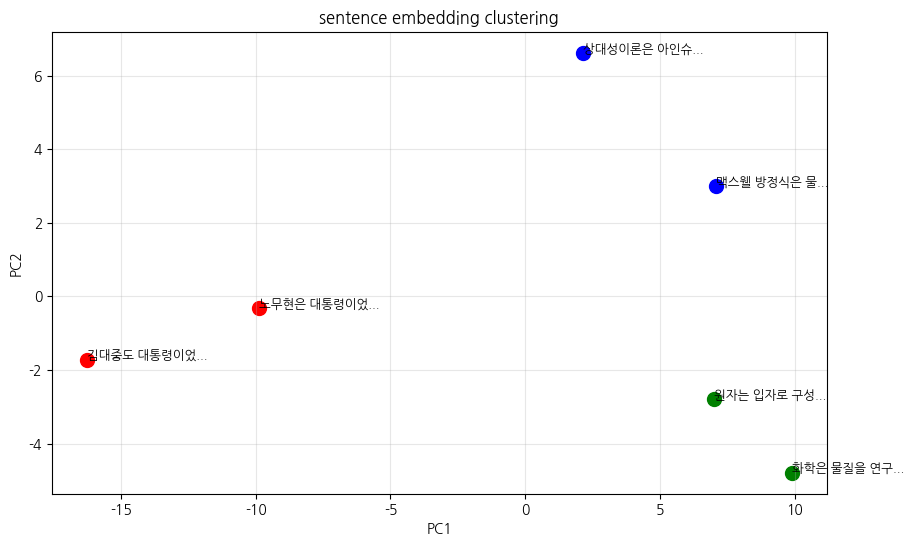

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 256차원 → 2차원으로 축소
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 그래프
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']
labels = ['politics', 'physics', 'chemistry']

for i in range(len(sentences)):
    plt.scatter(
        embeddings_2d[i, 0],
        embeddings_2d[i, 1],
        c=colors[clusters[i]],
        s=100
    )
    plt.annotate(
        sentences[i][:10] + '...',
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        fontsize=9
    )

plt.title('sentence embedding clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# FAQ 시스템
questions = [
    "화학이란 무엇인가?",
    "원자는 어떻게 구성되나?",
    "노무현은 몇 대 대통령인가?",
]

answers = [
    "화학은 물질의 성질과 변화를 연구하는 학문입니다.",
    "원자는 양성자, 중성자, 전자로 구성됩니다.",
    "노무현은 제16대 대통령입니다.",
]

# 질문 임베딩
q_embeddings = torch.stack([
    get_embeddings(bert_lm, vocab, q, device)
    for q in questions
])

# 사용자 질문
user_query = "한국 대통령이 궁금해"
user_emb = get_embeddings(bert_lm, vocab, user_query, device)

# 가장 유사한 질문 찾기
similarities = F.cosine_similarity(
    user_emb.unsqueeze(0),
    q_embeddings,
    dim=1
)
best_match = similarities.argmax().item()

print(f"질문: {user_query}")
print(f"매칭된 FAQ: {questions[best_match]}")
print(f"답변: {answers[best_match]}")

질문: 한국 대통령이 궁금해
매칭된 FAQ: 노무현은 몇 대 대통령인가?
답변: 노무현은 제16대 대통령입니다.


회고:

MLM 관련 태스크는 성능이 저열하다. 13%니 어떻게 보면 당연하다.
반면 NSP task prediction은 그래도 답을 높은 확률로 맞추는것도 있고 (원자와 히라가나; 맥스웰 초월수; 원자 히라가나; 등등).

다만, 매우 높은 확률로 틀린 답을 예측하는 모습도 보이는데 아마 훈련이 덜 됬기 때문인걸로 생각된다.
100 epoch 정도로 높여서 돌리고 싶은 생각도 있지만 코랩 credit이 아깝기 때문에 여기서 끝내야할듯 하다.

그외에는 클러스터링이 샘플 테스트 문장에서 각기 다른곳에 된 모습을 볼 수 있다. 도메인 별로 문맥이 학습이 잘된것 같다.

개인적으로 버트 모델 자체는 공부하는 재미가 별로 없었다. 기존 트랜스포머 인코더 가지고와서 임베딩 좀 다채롭게 한거 제외하고는 fine-tuning하고 우와 nlp task 성능 좋다는건 사실 GPT-1에서 이미 봤었기 때문에 많이 심심하다. 이러니까 오픈에이아이 한테 따잇당하지 라는 나쁜말은 하고 싶지 않지만 솔직히 자기들이 먼저 트랜스포머 논문 내놓고서는 후발주자 포지션이 되는 어이없는 모습을 보였으면서 '쟤네는 디코더 가지고 했으니 우리는 인코더 가지고 하고 음 이게 Bi-directional이니까 문맥 더 잘 파악해!!!로 주장하자'정도의 내용물은 짜치는거 같다 (의도한게 그게 아니고 성능이 실제로 잘 나왔다고는 해도 말이다). 지금에 이르러서는 gemini 조차 encoder-decoder 기반 모델이라는 점에서 더더욱...

별개로 버트 논문은 수식이 거의 없어서 읽는게 많이 귀찮았다.
대체적으로 수식 위주로 읽고 이해하면 코드 읽을 때 수월한데 없어서 강제로 읽어야했는데 Input Representation은 Segment Embedding 그냥 sentence A & B에 속한 토큰들에게 각각 둘중 하나의 (A에 속하면 A의 임베딩 값을) 768D 임베딩 값 더해줘서 Cartesian Plane 상으로 따지면 서로 멀리 떨어트리면서 기존 문장내 단어간의 상대적 벡터공간에서의 거리를 유지하겠다는거고 Token Embedding은 워드 임베딩 방식으로 VOCABULARY X 768 lookup 스타일로 만든걸로 유추되는데 제대로 설명도 안하고 이게 뭐하는 짓거리인지 모르겠다. 공간이 없으면 수식 몇개라도 던져놓으면 되는거 아닌가? 여튼, 수식은 없고 뭘 얘기하는건지 명확하지 않아서 계속 이런저런 레퍼런스 찾아서 읽고 정리하고 굉장히 짜증나는 논문이었다.

남은 논문들은 차라리 수식적으로 괴랄했으면 좋겠다. 차라리 머리 싸매고 고생하는게 낫지 이게 그건가 맞는가 스무고개식으로 의미하는게 뭔지 파악하느라 시간날리고 싶지 않다.
